In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from shutil import rmtree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import sys
sys.path.insert(0, "../Code/")
from train import train_eval

SPLIT_SEED = 0


In [2]:
def load(dataset):
    if dataset == "adult":

        data = pd.read_csv("../fairness-comparison/fairness/data/preprocessed/adult_numerical-binsensitive.csv")

        colnames = list(data)

        for name in colnames:
            if name[:7] == "native-" or name[:8] == "marital-":
                data.drop(labels = [name], inplace = True, axis = 1)

        print("Features that we are considering")
        print(list(data))

        x_full = data.drop(labels = ["income-per-year"], inplace = False, axis = 1).values
        y_full = data["income-per-year"].values

    elif dataset == "ricci":

        data = pd.read_csv("../fairness-comparison/fairness/data/preprocessed/ricci_numerical-binsensitive.csv")

        print("Features that we are considering")
        print(list(data))

        x_full = data.drop(labels = ["Combine"], inplace = False, axis = 1).values
        y_full = 1 * (data["Combine"].values > 70)

    elif dataset == "german":

        data = pd.read_csv("../fairness-comparison/fairness/data/preprocessed/german_numerical-binsensitive.csv")

        print("Features that we are considering")
        print(list(data))

        x_full = data.drop(labels = ["credit"], inplace = False, axis = 1).values
        y_full = data["credit"].values % 2 # original: 2 -> bad, 1-> good

    print("Final Dimensions")
    print(x_full.shape)
    print(y_full.shape)
    
    return x_full, y_full

In [3]:
def run_baseline(x, y):

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = SPLIT_SEED)
    
    scaler = StandardScaler()

    scaler.fit(x_train)

    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    
    model_lr = LogisticRegression().fit(x_train, y_train)
    print("Linear Acc: ", model_lr.score(x_test, y_test))
    
    model_svm = SVC().fit(x_train, y_train)
    print("SVM Acc: ", model_svm.score(x_test, y_test))
    
    model_rf = RandomForestClassifier().fit(x_train, y_train)
    print("RF Acc: ", model_rf.score(x_test, y_test))
    
    pred_lr = model_lr.predict(x_test)
    pred_svm = model_svm.predict(x_test)
    pred_rf = model_rf.predict(x_test)

    print("Linear & SVM Agreement: ", np.mean(pred_lr == pred_svm))
    print("Linear & RF Agreement: ", np.mean(pred_lr == pred_rf))
    print("SV & RF Agreement: ", np.mean(pred_svm == pred_rf))


In [4]:
x, y = load("adult")
run_baseline(x, y)

Features that we are considering
['age', 'education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'income-per-year', 'race-sex', 'workclass_Federal-gov', 'workclass_Local-gov', 'workclass_Private', 'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc', 'workclass_State-gov', 'workclass_Without-pay', 'education_10th', 'education_11th', 'education_12th', 'education_1st-4th', 'education_5th-6th', 'education_7th-8th', 'education_9th', 'education_Assoc-acdm', 'education_Assoc-voc', 'education_Bachelors', 'education_Doctorate', 'education_HS-grad', 'education_Masters', 'education_Preschool', 'education_Prof-school', 'education_Some-college', 'occupation_Adm-clerical', 'occupation_Armed-Forces', 'occupation_Craft-repair', 'occupation_Exec-managerial', 'occupation_Farming-fishing', 'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct', 'occupation_Other-service', 'occupation_Priv-house-serv', 'occupation_Prof-specialty', 'occupation_Protective-serv', 'occupat

/home/gregory/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/gregory/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/gregory/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/gregory/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Linear Acc:  0.8387481766343986
SVM Acc:  0.8421959952260973
RF Acc:  0.8346373160058348


/home/gregory/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Linear & SVM Agreement:  0.9474870706802812
Linear & RF Agreement:  0.8847632939928392
SV & RF Agreement:  0.8921893648057286


In [5]:
def eval_adult(sess, pred, pred_binary, perf_op, X, Y, x, y):

        n = x.shape[0]
        diffs = np.zeros((3))
        
        pred_original = sess.run(pred, {X: x})
        
        # Test the affect of increasing Age (feature at index 0)
        x_inc = np.copy(x)
        x_inc[:, 5] += 1
        pred_inc = sess.run(pred, {X: x_inc})
        diffs[0] = np.mean(pred_inc - pred_original)
        
        # Test the affect of changing Race (feature at index 2)    
        x_swap = np.copy(x)
        x_swap[:, 2] = (x_swap[:, 2] + 1) % 2
        pred_swap = sess.run(pred, {X: x_swap})
        diffs[1] = np.sqrt(np.mean((pred_swap - pred_original) ** 2))
        
        # Test the affect of changing Sex (feature at index 3)    
        x_swap = np.copy(x)
        x_swap[:, 3] = (x_swap[:, 3] + 1) % 2
        pred_swap = sess.run(pred, {X: x_swap})
        diffs[2] = np.sqrt(np.mean((pred_swap - pred_original) ** 2))
        
        # Compute TPR TNR for Race and Sex
        TPR_race = np.zeros((2))
        TPR_race_count = np.zeros((2))
        TNR_race = np.zeros((2))
        TNR_race_count = np.zeros((2))
        
        TPR_sex = np.zeros((2))
        TPR_sex_count = np.zeros((2))
        TNR_sex = np.zeros((2))
        TNR_sex_count = np.zeros((2))
        
        decisions = sess.run(pred_binary, {X: x})
        for i in range(n):
            g_r = x[i, 2]
            g_s = x[i, 3]
            if y[i] == 0:
                TNR_race_count[g_r] += 1
                TNR_sex_count[g_s] += 1
                if decisions[i] == 0:
                    TNR_race[g_r] += 1
                    TNR_sex[g_s] += 1
            else:
                TPR_race_count[g_r] += 1
                TPR_sex_count[g_s] += 1
                if decisions[i] == 1:
                    TPR_race[g_r] += 1
                    TPR_sex[g_s] += 1
        
        out = {}
        out["Model Acc"] = sess.run(perf_op, {X: x, Y: y})
        out["Mean affect of increasing age by 1"] = diffs[0]
        out["RMSE of changing Race"] = diffs[1]
        out["RMSE of changing Sex"] = diffs[2]
        out["TPR_race"] = TPR_race / TPR_race_count
        out["TNR_race"] = TNR_race / TNR_race_count
        out["TPR_sex"] = TPR_sex / TPR_sex_count
        out["TNR_sex"] = TNR_sex / TNR_sex_count
        return out

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = SPLIT_SEED)
    
if os.path.exists("TB/Adult/"):
    rmtree("TB/Adult/")

hidden_layer_sizes = [150, 150, 150]
learning_rate = 0.005
min_epochs = 5
stopping_epochs = 5

ntrials = 20
  
output_none = []
for trial in range(ntrials):
    output_none.append(train_eval(x_train, np.expand_dims(y_train, 1), "binary_classification", 
               hidden_layer_sizes = hidden_layer_sizes, learning_rate = learning_rate, min_epochs = min_epochs, stopping_epochs = stopping_epochs, 
               eval_func = eval_adult, x_test = x_test, y_test = np.expand_dims(y_test, 1), flag = "UCI",
               name = "TB/Adult/trial" + str(trial) + "/"))

output_reg = []
for trial in range(ntrials):
    output_reg.append(train_eval(x_train, np.expand_dims(y_train, 1), "binary_classification", 
           hidden_layer_sizes = hidden_layer_sizes, learning_rate = learning_rate, min_epochs = min_epochs, stopping_epochs = stopping_epochs,
           eval_func = eval_adult, x_test = x_test, y_test = np.expand_dims(y_test, 1), flag = "UCI",
           name = "TB/Adult/trial" + str(trial) + "/",
           heuristics = [["inv", 0, 4, 1.0], ["inv", 2, 0.5, 1000.0], ["inv", 3, 0.5, 1000.0]]))
    
output_aug = []
for trial in range(ntrials):
    n, d = x_train.shape

    x_train_augmented = np.zeros((3 * n, d))
    y_train_augmented = np.zeros((3 * n, 1))

    for i in range(n):
        x_curr = x_train[i]

        x_train_augmented[3 * i] = x_curr

        x_curr[2] = (x_curr[2] + 1) % 2 #Switch Race
        x_curr[0] += np.random.uniform(-3, 3)

        x_train_augmented[3 * i + 1] = x_curr

        x_curr = x_train[i]
        x_curr[3] = (x_curr[3] + 1) % 2 #Switch Sex
        x_curr[0] += np.random.uniform(-3, 3)

        x_train_augmented[3 * i + 2] = x_curr

        y_train_augmented[3 * i] = y_train[i]
        y_train_augmented[3 * i + 1] = y_train[i]
        y_train_augmented[3 * i + 2] = y_train[i]
    
    output_aug.append(train_eval(x_train_augmented, y_train_augmented, "binary_classification", 
               hidden_layer_sizes = hidden_layer_sizes, learning_rate = learning_rate, min_epochs = min_epochs, stopping_epochs = stopping_epochs,
               eval_func = eval_adult, x_test = x_test, y_test = np.expand_dims(y_test, 1), flag = "UCI",
               name = "TB/Adult/trial" + str(trial) + "/augmented/"))

INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tenso

0.8258387595415115   0.14984421895751437   0.8872080605477095   2.0817514307796956
0.8253746271133423   -0.0013436674329568633   0.0032221608358668163   0.0028948233026312663
0.8250961512327194   0.12095641260966658   1.256153716146946   1.0899050001986326


/home/gregory/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


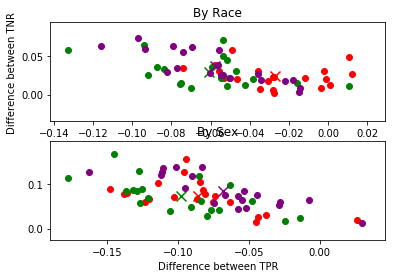

In [7]:
fig = plt.figure()

def aggregate_adult(out_list, c = "red"):
    acc = 0.0
    age = 0.0
    race = 0.0
    sex = 0.0
    tp_race = []
    tn_race = []
    tp_sex = []
    tn_sex = []
    count = 0
    for out in out_list:   
        acc += out["Model Acc"]
        age += out["Mean affect of increasing age by 1"]
        race += out["RMSE of changing Race"]
        sex += out["RMSE of changing Sex"]
        tp_race.append(out["TPR_race"][0] - out["TPR_race"][1])
        tn_race.append(out["TNR_race"][0] - out["TNR_race"][1])
        tp_sex.append(out["TPR_sex"][0] - out["TPR_sex"][1])
        tn_sex.append(out["TNR_sex"][0] - out["TNR_sex"][1])
        count += 1
    acc /= count
    age /= count
    race /= count
    sex /= count
    print(acc, " ", age, " ", race, " ", sex)
    
    ax = fig.add_subplot(2,1,1)
    plt.scatter(tp_race, tn_race, color = c)
    plt.scatter(np.mean(tp_race), np.mean(tn_race), color = c, marker = "x", s = 100)
    plt.ylabel("Difference between TNR")
    plt.title("By Race")
    
    ax = fig.add_subplot(2,1,2)
    plt.scatter(tp_sex, tn_sex, color = c)
    plt.scatter(np.mean(tp_sex), np.mean(tn_sex), color = c, marker = "x", s = 100)
    plt.xlabel("Difference between TPR")
    plt.title("By Sex")
    
aggregate_adult(output_none, c = "red")
aggregate_adult(output_reg, c = "green")
aggregate_adult(output_aug, c = "purple")

plt.show()

In [8]:
x, y = load("german")
run_baseline(x, y)

Features that we are considering
['month', 'credit_amount', 'investment_as_income_percentage', 'sex', 'residence_since', 'age', 'number_of_credits', 'people_liable_for', 'credit', 'sex-age', 'status_A11', 'status_A12', 'status_A13', 'status_A14', 'credit_history_A30', 'credit_history_A31', 'credit_history_A32', 'credit_history_A33', 'credit_history_A34', 'purpose_A40', 'purpose_A41', 'purpose_A410', 'purpose_A42', 'purpose_A43', 'purpose_A44', 'purpose_A45', 'purpose_A46', 'purpose_A48', 'purpose_A49', 'savings_A61', 'savings_A62', 'savings_A63', 'savings_A64', 'savings_A65', 'employment_A71', 'employment_A72', 'employment_A73', 'employment_A74', 'employment_A75', 'other_debtors_A101', 'other_debtors_A102', 'other_debtors_A103', 'property_A121', 'property_A122', 'property_A123', 'property_A124', 'installment_plans_A141', 'installment_plans_A142', 'installment_plans_A143', 'housing_A151', 'housing_A152', 'housing_A153', 'skill_level_A171', 'skill_level_A172', 'skill_level_A173', 'skill_

/home/gregory/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/gregory/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/gregory/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/gregory/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Linear Acc:  0.732
SVM Acc:  0.744
RF Acc:  0.728
Linear & SVM Agreement:  0.932
Linear & RF Agreement:  0.804
SV & RF Agreement:  0.824


/home/gregory/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [9]:
def eval_german(sess, pred, pred_binary, perf_op, X, Y, x, y):

        n = x.shape[0]
        diffs = np.zeros((2))
        
        pred_original = sess.run(pred, {X: x})
        
        # Test the affect of changing Sex (feature at index 3)    
        x_swap = np.copy(x)
        x_swap[:, 3] = (x_swap[:, 3] + 1) % 2
        pred_swap = sess.run(pred, {X: x_swap})
        diffs[0] = np.sqrt(np.mean((pred_swap - pred_original) ** 2))
        
        # Test the affect of increasing Age (feature at index 5)
        x_inc = np.copy(x)
        x_inc[:, 5] += 1
        pred_inc = sess.run(pred, {X: x_inc})
        diffs[1] = np.mean(pred_inc - pred_original)
        
        # Compute TPR TNR for Sex
        TPR = np.zeros((2))
        TPR_count = np.zeros((2))
        TNR = np.zeros((2))
        TNR_count = np.zeros((2))
        decisions = sess.run(pred_binary, {X: x})
        for i in range(n):
            group = x[i, 3]
            if y[i] == 0:
                TNR_count[group] += 1
                if decisions[i] == 0:
                    TNR[group] += 1
            else:
                TPR_count[group] += 1
                if decisions[i] == 1:
                    TPR[group] += 1
                    

        out = {}
        out["Model Acc"] = sess.run(perf_op, {X: x, Y: y})
        out["RMSE of changing Sex"] = diffs[0]
        out["Mean affect of increasing age by 1"] = diffs[1]
        out["TPR"] = TPR / TPR_count
        out["TNR"] = TNR / TNR_count
        return out


In [12]:

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = SPLIT_SEED)

hidden_layer_sizes = [150]
learning_rate = 0.005
min_epochs = 5
stopping_epochs = 5

ntrials = 20
    
if os.path.exists("TB/German/"):
    rmtree("TB/German/")

output_none = []
for trial in range(ntrials):
    output_none.append(train_eval(x_train, np.expand_dims(y_train, 1), "binary_classification", 
           hidden_layer_sizes = hidden_layer_sizes, learning_rate = learning_rate, min_epochs = min_epochs, stopping_epochs = stopping_epochs,
           eval_func = eval_german, x_test = x_test, y_test = np.expand_dims(y_test, 1), flag = "UCI", 
           name = "TB/German/trial" + str(trial) + "/"))

output_reg = []
for trial in range(ntrials):
    output_reg.append(train_eval(x_train, np.expand_dims(y_train, 1), "binary_classification", 
           hidden_layer_sizes = hidden_layer_sizes, learning_rate = learning_rate, min_epochs = min_epochs, stopping_epochs = stopping_epochs,
           eval_func = eval_german, x_test = x_test, y_test = np.expand_dims(y_test, 1), flag = "UCI", 
           name = "TB/German/trial" + str(trial) + "/",
           heuristics = [["inv", 3, 0.5, 1000.0], ["inv", 5, 3.0, 1.0]]))
    
output_aug = []
for trial in range(ntrials):
    n, d = x_train.shape

    x_train_augmented = np.zeros((2 * n, d))
    y_train_augmented = np.zeros((2 * n, 1))

    for i in range(n):
        x_curr = x_train[i]

        x_train_augmented[2 * i] = x_curr

        x_curr[3] = (x_curr[3] + 1) % 2 #Switch Sex
        x_curr[5] += np.random.uniform(-3, 3)

        x_train_augmented[2 * i + 1] = x_curr

        y_train_augmented[2 * i] = y_train[i]
        y_train_augmented[2 * i + 1] = y_train[i]

    output_aug.append(train_eval(x_train_augmented, y_train_augmented, "binary_classification", 
               hidden_layer_sizes = hidden_layer_sizes, learning_rate = learning_rate, min_epochs = min_epochs, stopping_epochs = stopping_epochs,
               eval_func = eval_german, x_test = x_test, y_test = np.expand_dims(y_test, 1), flag = "UCI", 
               name = "TB/German/trial" + str(trial) + "/augmented/"))  


INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tensorflow:Restoring parameters from ./model.cpkt
INFO:tenso

0.7200000017881394   0.5914884425699711   0.6246578794904053
0.7235999971628189   0.001982719844090752   0.002471090602921322
0.7362000048160553   0.3877836771309376   0.0703480888158083


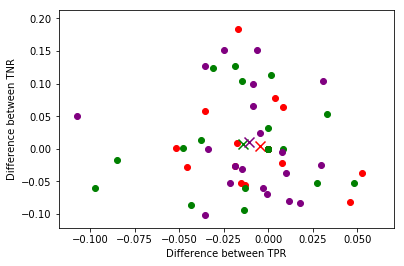

In [13]:
def aggregate_german(out_list, c = "red"):
    acc = 0.0
    sex = 0.0
    age = 0.0
    tp = []
    tn = []
    count = 0
    for out in out_list:
        count += 1
        acc += out["Model Acc"]
        sex += out["RMSE of changing Sex"]
        age += out["Mean affect of increasing age by 1"]
        tp.append(out["TPR"][0] - out["TPR"][1])
        tn.append(out["TNR"][0] - out["TNR"][1])
    acc /= count
    sex /= count
    age /= count
    print(acc, " ", sex, " ", age)
    plt.scatter(tp, tn, color = c)
    plt.scatter(np.mean(tp), np.mean(tn), color = c, marker = "x", s = 100)
    plt.xlabel("Difference between TPR")
    plt.ylabel("Difference between TNR")
    
aggregate_german(output_none, c = "red")
aggregate_german(output_reg, c = "green")
aggregate_german(output_aug, c = "purple")

plt.show()
    